In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2, json, torch, os, re

import util, constants, draw, cam, model, loader, img_proc

np.random.seed(0)
torch.manual_seed(0)

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape_yx = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2];img_shape_xy = img_shape_yx[::-1]

uf_mat_int_default = cam.get_mat_intrinsic()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape_xy)

with open(VID_ROOT+'/md.json') as f:
    data = json.load(f)
    num_views, num_frames = data['num_views'], data['num_frames']
    
print(f'{num_views} views, {num_frames} frames')
print(f'img_shape_xy: {img_shape_xy}')

3 views, 90 frames
img_shape_xy: (1280, 720)


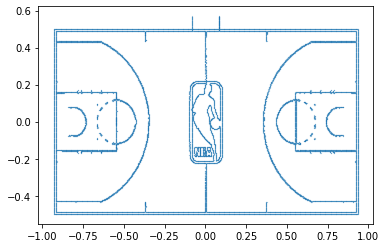

In [3]:
img = plt.imread(VID_ROOT+'/view_0/frame_00089.png')
img = (img*255/img.max()).astype(np.uint8)

court_img, court_bin = model.load_model_img(DATA_ROOT)
court_img = (court_img*255/court_img.max()).astype(np.uint8)

mat_model = model.get_mat_model(model.load_model_corners(DATA_ROOT))

X_w = model.calc_model_world_coordinates(DATA_ROOT)
plt.scatter(X_w[:, 0], X_w[:, 1], marker='.', s=0.1);plt.show()

In [4]:
dofs_cam = np.load(VID_ROOT+'/dofs_cam.npy')
dofs_cam.shape

(3, 90, 7)

In [5]:
"""
i={0, 1}
xi is the a point on the line
vi is the vector of the line
xi+vi*ti is the closest point on the line


vd is the vector of the perpendicular line
td is the amount to travel along this perpendicular vector to get to the other line
x0 + v0*t0 + vd*td = x1+ v1*t1

"""
def calc_skew(x0, v0, x1, v1):
    vd = np.cross(v0, v1, axis=-1)
    # normalize vd
    vd = vd/np.linalg.norm(vd, axis=-1, keepdims=True)
    A = np.stack([v0, -v1, vd], axis=-1)
    b = (x1-x0)[..., None]
    t = np.linalg.solve(A, b)
    t0, t1, td = t[..., 0, :], t[..., 1, :], t[..., 2, :]
    return t0, t1, td, vd

In [58]:
kp, confs, scores, boxes = loader.load_alphapose_kp(VID_ROOT, num_frames)

In [59]:
for view_idx in range(num_views):
    for frame_idx in range(num_frames):
        for p_idx in range(len(confs[view_idx, frame_idx])-1, -1, -1):
            c = confs[view_idx, frame_idx][p_idx].mean(axis=-1)
            if c<0.46:
                del kp[view_idx, frame_idx][p_idx]
                del confs[view_idx, frame_idx][p_idx]
                del scores[view_idx, frame_idx][p_idx]
                del boxes[view_idx, frame_idx][p_idx]

In [60]:
x0s, vs = [], []
for view_idx in range(num_views):
    x0s_view, vs_view = [], []
    for frame_idx in range(num_frames):
        X_i_kp = np.array(kp[view_idx, frame_idx])
        mat_int = cam.get_intrinsic_mat_for_dofs_cam(dofs_cam[view_idx, frame_idx], img_shape_xy)
        mat_view = cam.get_mat_view(dofs_cam[view_idx, frame_idx])
        Rinv = np.linalg.inv(mat_view[:3, :3]) # camera to world
        
        X_c_kp_dir = np.linalg.inv(mat_int[:3, :3])@(util.to_homo(X_i_kp)[..., None])
        X_w_kp_dir = (Rinv @ X_c_kp_dir)[..., 0]
        X_base = np.tile(dofs_cam[view_idx, frame_idx, :3], X_w_kp_dir.shape[:-1]+(1,))
        x0s_view.append(X_base)
        vs_view.append(X_w_kp_dir)
    x0s.append(x0s_view)
    vs.append(vs_view)
    
x0s, vs = np.array(x0s), np.array(vs)

In [61]:
print(x0s.shape)
print(x0s[0,0].shape)

(3, 90)
(19, 17, 3)


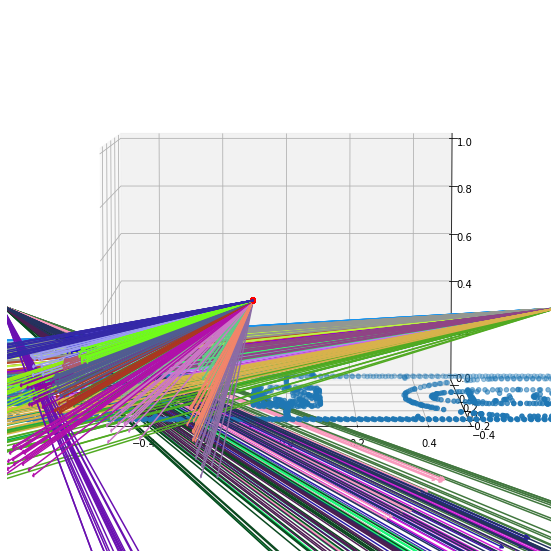

In [62]:
frame_idx = 0
plt.figure(figsize=(10, 10))
ax = plt.subplot(projection='3d')
ax.scatter3D(X_w[::10, 0], X_w[::10, 1], X_w[::10, 2])
for view_idx, (vs_i, x0s_i) in enumerate(zip(vs[:, frame_idx], x0s[:, frame_idx])):
#     if view_idx != 0:continue
    colors = np.random.uniform(0, 1, size=(len(vs_i),3))
    for x0, v, color in zip(x0s_i, vs_i, colors):
        ax.scatter3D(x0[:, 0],x0[:, 1], x0[:, 2], c='r')
        ax.quiver3D(x0[:, 0],x0[:, 1], x0[:, 2],
                    v[:, 0], v[:, 1], v[:, 2],
                    length=3, arrow_length_ratio=0.01, color=color)
    
ax.set_xlim(-.5, .5);ax.set_ylim(-.5, .5);ax.set_zlim(0,1)
# ax.set_xlim(-2, 2);ax.set_ylim(-2, 2);ax.set_zlim(0,4)
ax.view_init(5, 270)

In [63]:
view_idx0, view_idx1 = 0, 2
scores = [np.zeros([len(x0s[view_idx0, frame_idx]), len(x0s[view_idx1, frame_idx])]) for frame_idx in range(num_frames)]
pmids = [np.zeros([len(x0s[view_idx0, frame_idx]), len(x0s[view_idx1, frame_idx]), 17, 3]) for frame_idx in range(num_frames)]

In [80]:
for frame_idx in tqdm(range(num_frames)):
    for person_idx0, (x0, v0) in enumerate(zip(x0s[view_idx0, frame_idx], vs[view_idx0, frame_idx])):
        for person_idx1, (x1, v1) in enumerate(zip(x0s[view_idx1, frame_idx], vs[view_idx1, frame_idx])):
            t0, t1, td, vd = calc_skew(x0, v0, x1, v1)
            p0 = x0+v0*t0
            p1 = x1+v1*t1
            
            c0 = confs[view_idx0][frame_idx][person_idx0]
            c1 = confs[view_idx1][frame_idx][person_idx1]
            ca0, ca1 = c0/(c0+c1), c1/(c0+c1)
            
            
            pmid = (ca0[..., None]*p0+ca1[..., None]*p1)
#             pmid = (p0+p1)/2
            d = np.linalg.norm(p0-p1, axis=-1)
    #         score = d.mean()
            score = np.sort(d)[:10].mean()

            cost0 = 0.001*np.e**(-10*x-confs[view_idx0][frame_idx][person_idx0])
            cost1 = 0.001*np.e**(-10*x-confs[view_idx1][frame_idx][person_idx1])
            cost0 = np.sort(cost0)[-10:].mean()
            cost1 = np.sort(cost1)[-10:].mean()
            
            
            score += cost0+cost1
            
            scores[frame_idx][person_idx0, person_idx1] = score
            pmids[frame_idx][person_idx0, person_idx1] = pmid


In [81]:
import scipy.optimize

v0_p_idx, v1_p_idx = [], []
for frame_idx in tqdm(range(num_frames)):
    v0_p_idx_frame, v1_p_idx_frame = scipy.optimize.linear_sum_assignment(scores[frame_idx])
    mask = scores[frame_idx][v0_p_idx_frame, v1_p_idx_frame]<1./94.
    v0_p_idx_frame, v1_p_idx_frame = v0_p_idx_frame[mask], v1_p_idx_frame[mask]
    v0_p_idx.append(v0_p_idx_frame)
    v1_p_idx.append(v1_p_idx_frame)


In [82]:
pmids_chosen = [pmids[frame_idx][v0_p_idx[frame_idx], v1_p_idx[frame_idx]] for frame_idx in range(num_frames)]

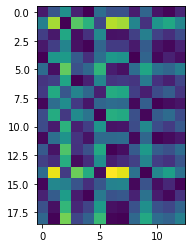

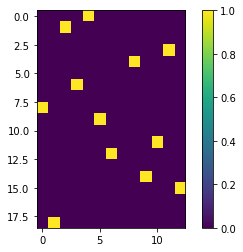

In [83]:
frame_idx = 0
plt.imshow(scores[frame_idx]);plt.show()

row, col = v0_p_idx[frame_idx], v1_p_idx[frame_idx]
temp = np.zeros_like(scores[frame_idx])
temp[row, col] = 1
plt.imshow(temp);plt.colorbar();plt.show()

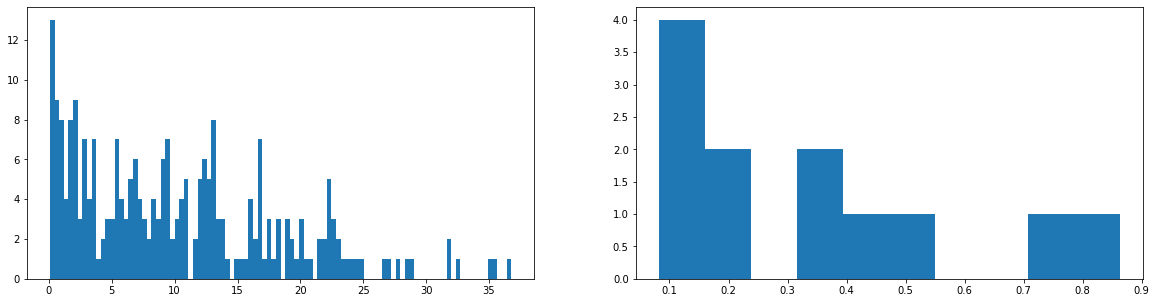

In [84]:
frame_idx=0
plt.figure(figsize=(20,5))
plt.subplot(121);plt.hist(scores[frame_idx].flatten()*94, bins=100)
plt.subplot(122);plt.hist(scores[frame_idx][row, col]*94, bins=10);plt.show()

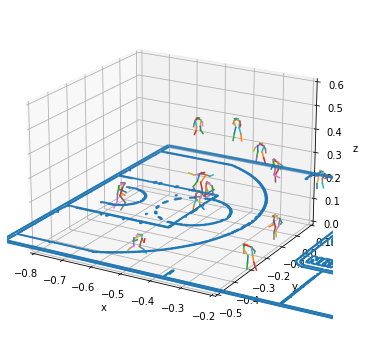

In [85]:
frame_idx = 0
%matplotlib inline

plt.figure(figsize=(6,6))
ax = plt.subplot(projection='3d')
draw.draw_people(pmids_chosen[frame_idx], ax)
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z')
ax.set_xlim(-0.8, -.2);ax.set_ylim(-.5, .1);ax.set_zlim(0,.6)
ax.scatter(*X_w[:].swapaxes(0,1), s=1)
ax.view_init(20, -60)
plt.savefig('temp.png')
plt.show()

In [96]:
for frame_idx in tqdm(range(num_frames)):
    plt.figure(figsize=(6,6))
    ax = plt.subplot(projection='3d')
    draw.draw_people(pmids_chosen[frame_idx], ax)
    ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z')
    ax.set_xlim(-0.8, -.2);ax.set_ylim(-.5, .1);ax.set_zlim(0,.6)
    ax.scatter(*X_w[:].swapaxes(0,1), s=1)
    ax.view_init(20, -110+int(frame_idx/90*360))
    plt.title(f'Frame {frame_idx:05d}')
    plt.savefig(f'{VID_ROOT}/viz_3d/frame_{frame_idx:05d}.png')
#     plt.show()
    plt.close()

In [97]:
VID_ROOT_ffmpeg = VID_ROOT.replace(' ', '\ ')
! rm {VID_ROOT_ffmpeg}/viz_3d/out.mp4
! ffmpeg -r 15 -i {VID_ROOT_ffmpeg}/viz_3d/frame_%05d.png -c:v libx264 -vf fps=15 -pix_fmt yuv420p {VID_ROOT_ffmpeg}/viz_3d/out.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

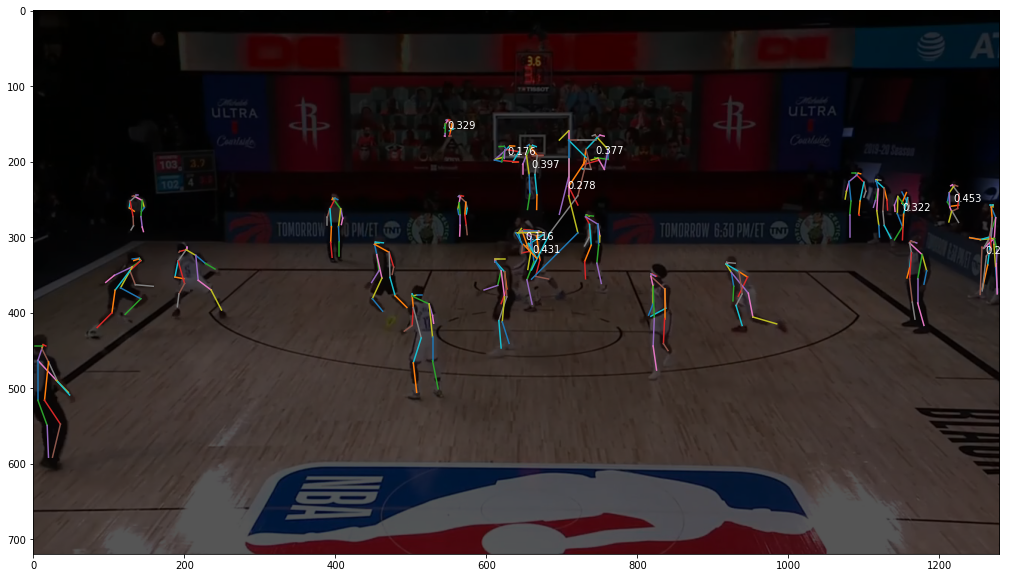

In [29]:
view_idx = 2
frame_idx = 34

img = loader.load_data_imgs(VID_ROOT, [view_idx], [frame_idx])[0,0]

plt.figure(figsize=(20, 10))
draw.draw_people(kp[view_idx][frame_idx])

for p_idx in range(len(confs[view_idx][frame_idx])):
    s = np.array(confs[view_idx][frame_idx][p_idx]).mean()
    if s<0.5:
        x, y = np.array(kp[view_idx][frame_idx][p_idx]).mean(axis=-2)
        plt.text(x, y, f'{s:0.03f}', c='w')
    
plt.imshow(img/3);plt.show()

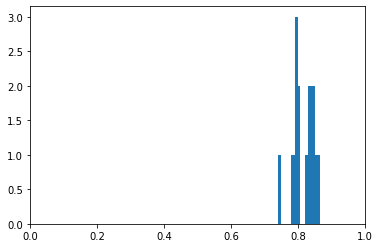

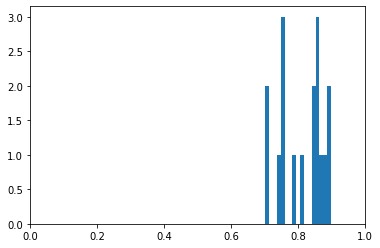

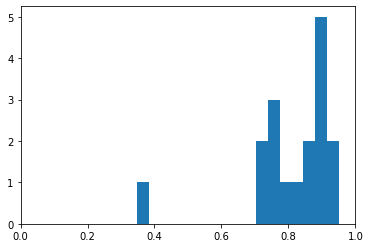

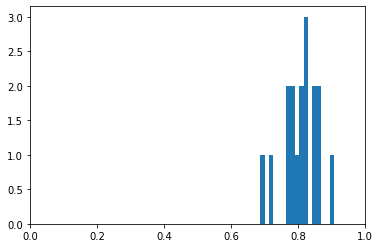

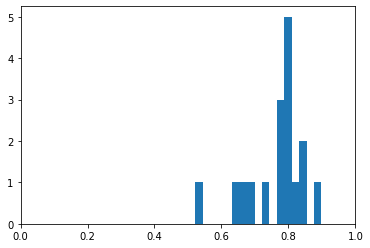

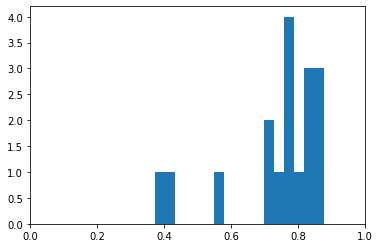

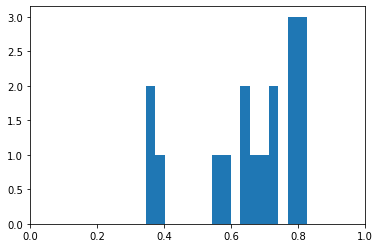

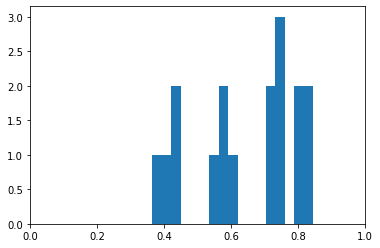

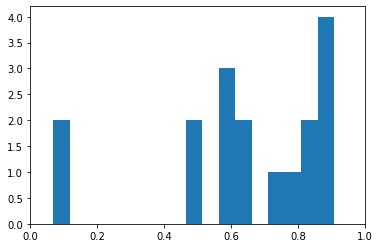

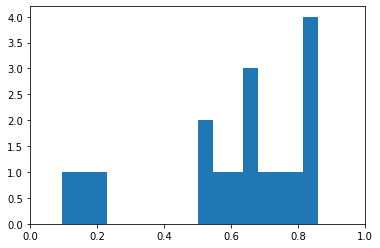

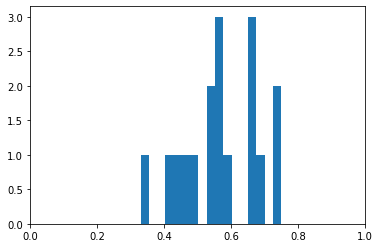

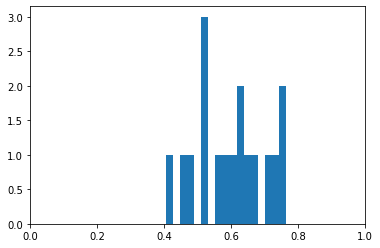

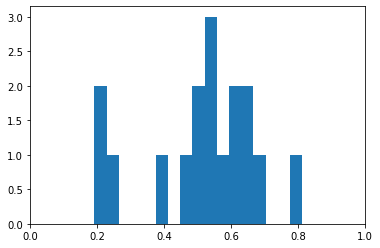

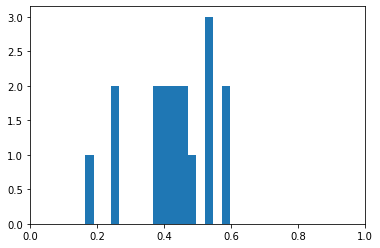

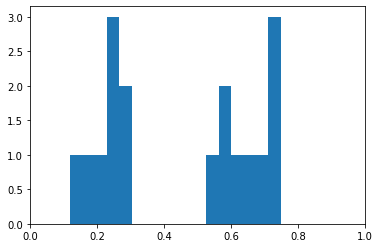

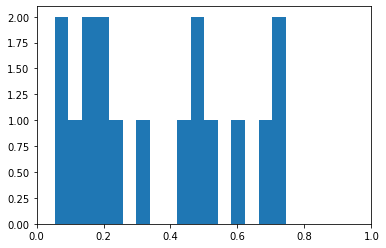

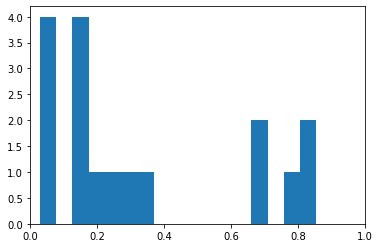

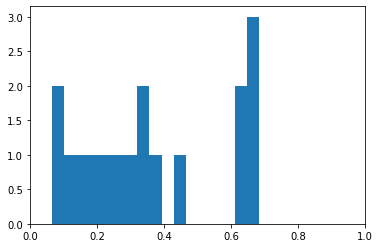

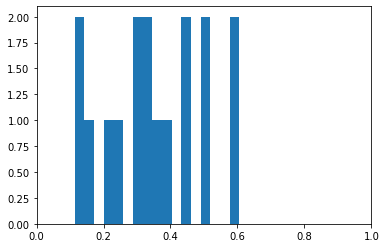

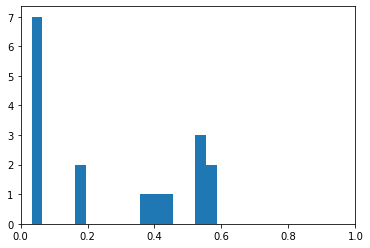

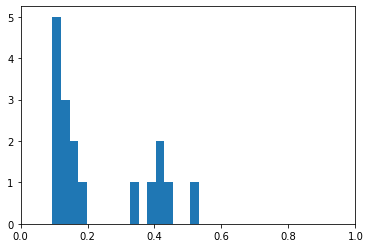

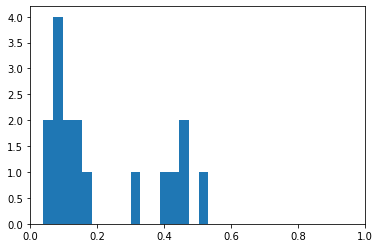

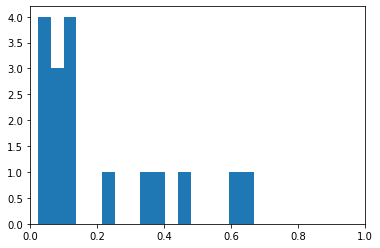

In [38]:
for p in confs[2][0]:
    plt.hist(p, bins=17)
    plt.xlim(0, 1)
    plt.show()